The goal of this notebook is to collect data for training a DQN to land the lunar lander

In [294]:
import pandas as pd
import importlib
import NeuralNetUtils as nnu
importlib.reload(nnu)
import matplotlib.pyplot as plt
from random import random, randint
from IPython import display

from NeuralNetUtils import NeuralNetwork, ReplayBuffer, DataSet

import gymnasium as gym
import numpy as np
from typing import List
import torch.nn as nn
import torch
torch.autograd.set_detect_anomaly(True)

Helpers specific to the lunar lander environment:

In [295]:
STATE_FEATURES = 8 # x, ẋ, y, ẏ, θ, θ*, rightlegtouching, leftlegtouching
ACTION_OPTIONS = 4 # do nothing, fire left, fire main, fire right
TOTAL_COLUMNS = STATE_FEATURES * 2 + ACTION_OPTIONS + 1 # S + A + R + S = 2*S + A + 1


#converts env state space into a more easily useable object
class EnvironmentState:
    def __init__(self,state):
        coord = state[0]
        self.x = coord[0]
        self.y = coord[1]
        self.x_dot = coord[2]
        self.y_dot = coord[3]
        self.theta = coord[4]
        self.theta_dot = coord[5]
        self.leftLegTouching = int(coord[6])
        self.rightLegTouching = int(coord[7])
        reward = 0
        isDone = False
        if len(state)>2:
            reward = state[1]
            isDone = state[2] or state[3]
        self.reward = reward
        self.isDone = isDone 
    
    def __repr__(self):
        lines = [
            f"(x, y): ({self.x}, {self.y})",
            f"(ẋ, ẏ): ({self.x_dot}, {self.y_dot})",
            f"θ: {self.theta}",
            f"dθ/dt: {self.theta_dot}",
            f"Legs touching (L,R): ({self.leftLegTouching}, {self.rightLegTouching})",
            f" Reward: {self.reward}",
            f" Done: {self.isDone}",
        ]
        return "\n".join(lines,)

    def toTensor(self):
        return nnu.convertToTensor(self.toArray().astype(np.float32))
    
    def toArray(self) -> np.ndarray:
        return np.array(self.toList())
    
    def toList(self) -> List[float]:
        return [self.x, self.y, self.x_dot, self.y_dot, self.theta, self.theta_dot, self.leftLegTouching, self.rightLegTouching]
    
# reads file to load a replay buffer
def LoadReplayBuffer(filePath : str) -> ReplayBuffer:

    start_index = 0
    def getNextColumns(columnCount : int) -> np.ndarray:
        nonlocal start_index
        end_index = start_index + columnCount
        outVar = arr[:,start_index: end_index]
        start_index = end_index
        return outVar

    df = pd.read_csv(filePath)
    arr = df.values

    
    S = getNextColumns(STATE_FEATURES)
    A = getNextColumns(ACTION_OPTIONS)
    R = getNextColumns(1)
    S_Prime = getNextColumns(STATE_FEATURES)
    
    return ReplayBuffer(S,A,R,S_Prime)


def SaveReplayBuffer(replayBuffer : ReplayBuffer, filePath : str):
    start_index = 0
    csvArray = np.ndarray((replayBuffer.Rows,TOTAL_COLUMNS))
    def setNextColumns(arr):
        arr = nnu.convertToNumpy(arr)
        nonlocal start_index, csvArray
        end_index = start_index + arr.shape[1]
        csvArray[:,start_index:end_index] = arr
        start_index = end_index
    
    setNextColumns(replayBuffer.S)
    setNextColumns(replayBuffer.A)
    setNextColumns(replayBuffer.R)
    setNextColumns(replayBuffer.S_Prime)

    column_names = ["x", "ẋ", "y", "ẏ", "θ", "dθ/dt", "L_touching", "R_touching", "Do Nothing", "Left Thruster", "Right Thruster", "Main Thruster","Reward","x'", "ẋ'", "y'", "ẏ'", "θ'", "dθ/dt'", "L_touching'", "R_touching'"]
    df = pd.DataFrame(csvArray,columns=column_names)
    df.to_csv(filePath,  index=False)

Here we define the reward function - a crucial item to tune

In [296]:
def Reward(state : EnvironmentState) -> float:
    return state.reward

Step 1: Collect a replay buffer (s,a,R,s'). Because this is ground-truth data (independent of model decisions / inference) we can use replay data regardless of how good the model was at the time the data was created

In [ ]:
DATA_SET_SIZE = 10000
EPSILON = 0.1


def CollectData(obj) -> ReplayBuffer:
    #input a string? load data from file    
    if isinstance(obj, str):         
        return LoadReplayBuffer(obj)
    if isinstance(obj, NeuralNetwork):
        network = obj
        return CollectDataFromModel(
            policyNetwork=network,
            batchSize=DATA_SET_SIZE,
            epsilon=EPSILON)
    
def get_decision(state: torch.Tensor, policy_network: NeuralNetwork, epsilon: float) -> int:
    if random() < epsilon:
        return randint(0,ACTION_OPTIONS-1)
    q = nnu.convertToNumpy(policy_network.forward(state))
    return np.argmax(q)

def generate_game(render_mode:str = None):
    GAME_NAME = 'LunarLander-v3'
    env = gym.make(GAME_NAME, render_mode=render_mode)
    return env

def CollectDataFromModel(policyNetwork : NeuralNetwork, batchSize : int, epsilon: float ) -> ReplayBuffer:    
    env = generate_game()
    state = EnvironmentState(env.reset())

    def initializeArray(rows : int, cols : int) -> np.ndarray:
        return np.full((rows, cols), np.nan, dtype=np.float32)

    S = initializeArray(batchSize,STATE_FEATURES)
    A = initializeArray(batchSize,ACTION_OPTIONS)
    R = initializeArray(batchSize,1)
    S_Prime = initializeArray(batchSize,STATE_FEATURES)

    gamesPlayed = 0
    
    for i in range(batchSize):
        stateArray = state.toArray()
        S[i,:] = stateArray  # Update S for this row
        R[i,0] = Reward(state) # Update R for this row

        if(state.isDone):
            gamesPlayed += 1
            state = EnvironmentState(env.reset())
            continue
        
        stateTensor = nnu.convertToTensor(stateArray)
        decision = get_decision(
            policy_network=policyNetwork,
            state=stateTensor,
            epsilon=epsilon)
        a = np.zeros((1,ACTION_OPTIONS))
        a[0,decision] = 1
        A[i,:] = a # Update A for this row
        state = EnvironmentState(env.step(decision))
        S_Prime[i,:] = state.toArray() # Update S_Prime for this row
        nnu.printLoadBar(i/batchSize)
    nnu.printLoadBar(1)
    print(F"\nPlayed {gamesPlayed} full games")
    return ReplayBuffer(S, A, R, S_Prime)



#model architecture

hiddenLayers = [1000,1000,1000,4]
activationFunctions = [nn.ReLU(), nn.ReLU(), nn.ReLU(),None]
policy_network = NeuralNetwork(STATE_FEATURES, hiddenLayers, activationFunctions)
target_network = policy_network.copy()
trainingParams = nnu.TrainingParams() 
trainingParams.learningRate = 1e-2 # learning rate of the policy network during training steps
trainingParams.regularizationConstant = 1e-1 # regularization constant used to train the policy network
trainingParams.iterations = 60 # iterations of training when we train the policy network on any given subset of the 
loss = nn.CrossEntropyLoss()
gamma = 0.99 #time decay of reward


replayBufferName = "lunarlanderReplayBuffer.csv"

generateNewData = False
dataCollectionTool = policy_network
if not generateNewData:
    dataCollectionTool = replayBufferName

data = CollectData(replayBufferName)
samplingRatio = 0.1





Save the data

In [298]:
if generateNewData:
    SaveReplayBuffer(data,replayBufferName)

Ok let's run inference on the replay buffer:

In [ ]:
X = data.S #S, A
q_s_prime = target_network.forward(X) # n x q tensor where n = number of rows and q = number of action possibilities
Y = data.R + q_s_prime * gamma

torch.Size([10000, 8])


Now, for each epoch, let's train the policy model on a subset of the X/Y dataset

In [300]:


EPOCHS = 10

data_set = DataSet(X,Y)
for i in range(EPOCHS):
    sub_set = data_set.sub_sample(1/EPOCHS)
    result = nnu.trainModel(
        trainData=sub_set,
        model=policy_network,
        loss_function=loss,
        trainingParams=trainingParams,
        shouldPrint=True)

Training Model. Features 8, Samples 1000. Iterations: 60
Running on NVIDIA GeForce GTX 1080
Training Model. Features 8, Samples 1000. Iterations: 60
Running on NVIDIA GeForce GTX 1080
Training Model. Features 8, Samples 1000. Iterations: 60
Running on NVIDIA GeForce GTX 1080
Training Model. Features 8, Samples 1000. Iterations: 60
Running on NVIDIA GeForce GTX 1080
Training Model. Features 8, Samples 1000. Iterations: 60
Running on NVIDIA GeForce GTX 1080
Training Model. Features 8, Samples 1000. Iterations: 60
Running on NVIDIA GeForce GTX 1080
Training Model. Features 8, Samples 1000. Iterations: 60
Running on NVIDIA GeForce GTX 1080
Training Model. Features 8, Samples 1000. Iterations: 60
Running on NVIDIA GeForce GTX 1080
Training Model. Features 8, Samples 1000. Iterations: 60
Running on NVIDIA GeForce GTX 1080
Training Model. Features 8, Samples 1000. Iterations: 60
Running on NVIDIA GeForce GTX 1080


Let's see how our model is doing:

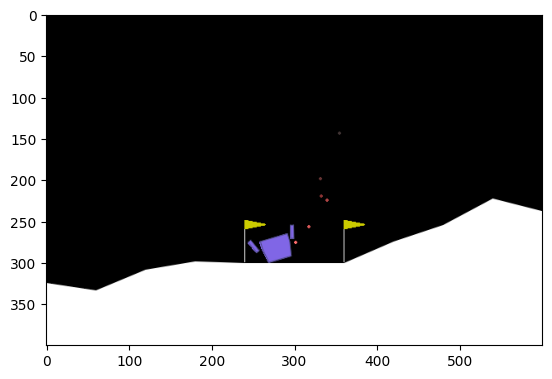

In [302]:
fig, ax = plt.subplots()

def RenderFrame(env,envState=None,debugText = None):
    ax.clear()  # Clear the previous image
    arr = env.render()
    ax.imshow(arr)
    def DisplayData():
        if debugText is not None: ax.text(50,100,debugText, color="yellow")
        if envState is not None: ax.text(1,1,F"(X, Y): ({envState.x}, {envState.y})")
    DisplayData()
    display.display(fig)  # Display the figure object
    display.clear_output(wait=True)  # Clear the output for the next frame



def WatchModelPlay(policy_network: NeuralNetwork):
    env = generate_game(render_mode="rgb_array")
    state = EnvironmentState(env.reset())
    while not state.isDone:

        action = get_decision(
            policy_network=policy_network,
            state=nnu.convertToTensor(state.toArray()),
            epsilon=0)
        state = EnvironmentState(env.step(action))
        RenderFrame(env)



WatchModelPlay(policy_network=policy_network)

Well, it's not looking too hot. Let's let it train a whole lot more

In [ ]:
def FullTrainingCycle():
    target_network = policy_network.copy()
    replayBuffer = CollectData(policy_network)